In [54]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [55]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [56]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [57]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [58]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [59]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [60]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [61]:
# Create the inspector and connect it to the engine. Inspect tables
inspector = inspect(engine)

In [62]:
# Using the inspector to print the column names within the 'Measurement' table and its types
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [63]:
# Using the inspector to print the column names within the 'Station' table and its types
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [64]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [65]:
# Display the first row's columns and data in dictionary format.
## For Measurement table
first_rowMeasu = session.query(Measurement).first()
first_rowMeasu.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2c26b4430c8>,
 'id': 0,
 'date': '2010-01-01',
 'tobs': 18.3,
 'station': 'USC00519397',
 'prcp': 2.0}

In [66]:
# Display the first row's columns and data in dictionary format.
## For Station table
first_rowStatn = session.query(Station).first()
first_rowStatn.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2c26c0b4cc8>,
 'id': 0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 0.914}

In [67]:
# Examine how many dated records exist in data set.
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [68]:
# Find the earliest date in the data set.
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
print(earliest_date)

('2010-01-01',)


In [69]:
# Find the most recent date in the data set.

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

('2017-08-23',)


In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
mostrecent_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set. 
query_date = mostrecent_date - dt.timedelta(days=365)
print(query_date)

2016-08-23 00:00:00


In [71]:
# Perform a query to retrieve the data and precipitation scores
# Select only the "date" and "prcp" values.

sel = [Measurement.date, Measurement.prcp]

pastyear_precip = session.query(*sel).filter(Measurement.date >= query_date).all()

In [72]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Rename prcp column
# Sort the dataframe by date

prcp_df = pd.DataFrame(pastyear_precip, columns=['Date', 'Precipitation_Amount'])
prcp_df = prcp_df.dropna(how='any')
prcp_df = prcp_df.sort_values(['Date'], ascending=True)
prcp_df = prcp_df.set_index('Date')
prcp_df.head()

,Precipitation_Amount
Date,
2016-08-24,2.0
2016-08-24,31.0
2016-08-24,57.9
2016-08-24,36.8
2016-08-24,54.6


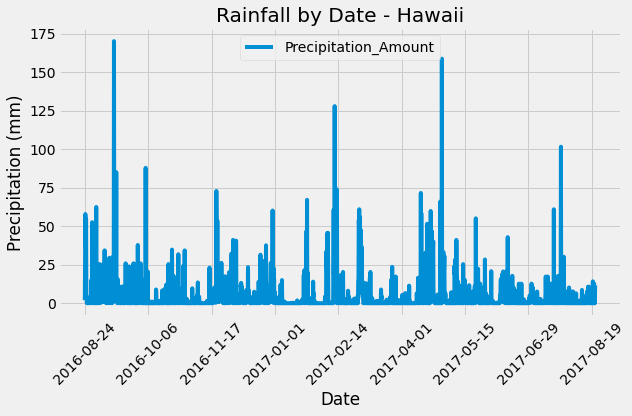

In [73]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(rot=45, title = "Rainfall by Date - Hawaii",figsize=(9,6))
plt.ylabel("Precipitation (mm)")
plt.tight_layout()
plt.show()
ax.figure.savefig('Precipitation Analysis_Hawaii.png')

In [74]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation_Amount
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [75]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [76]:
# Design a query to find the most active stations (i.e. what stations have the most rows?). 
# Most active station assumed to be station with the highest number of temperature observations (i.e., Measurement.ids)
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.id)]
activestations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

Station USC00519281 has the greatest number of observations.

In [77]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp:
    print(station)

('USC00519281', 12.2, 29.4, 22.03582251082252)


Highest temperature: 29.4 °C. 
Lowest temperature: 12.2 °C.
Average temperature: 22 °C.

In [78]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station.
sel = [Measurement.date, 
       Measurement.tobs]
pastyear_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= query_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Save results as a dataframe.
pastyear_temps_df = pd.DataFrame(pastyear_temps, columns=['Measurement Date', 'Temperature'])
pastyear_temps_df.head()

,Measurement Date,Temperature
0,2016-08-24,25.0
1,2016-08-25,26.7
2,2016-08-26,26.7
3,2016-08-27,23.9
4,2016-08-28,22.8


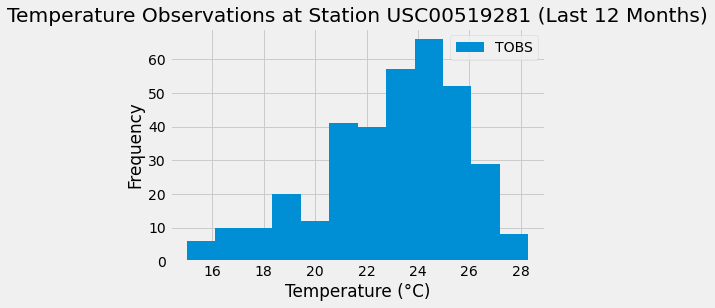

In [79]:
# Plot the results as a histogram.
plt.hist(pastyear_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at Station USC00519281 (Last 12 Months)")
plt.figsize=(16,8)
plt.savefig('Aug2016-2017_USC005192812.png')
plt.show()


# Close session

In [80]:
# Close Session
session.close()